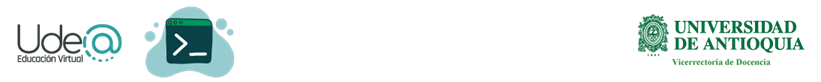

# Miniproyecto 1

**Estudiantes:**
*   Sebastian Orozco Blandon.
*   Maria Lucia Orozco Guerra

**Tratamiento de Señales III**

**Facultad de Ingeniería**

**Universidad de Antioquia**

---

In [ ]:
# Descargamos el archivo Emocional

#https://drive.google.com/file/d/1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3/view?usp=sharing
!gdown '1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3'

Downloading...
From: https://drive.google.com/uc?id=1bMObQcIFrNalRmD1LaNuqVSTeqaeGqR3
To: /content/s17.mat
100% 80.7M/80.7M [00:01<00:00, 49.8MB/s]


In [ ]:
# Cargar el archivo .mat
import scipy.io as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter, freqz, stft, find_peaks

#se pretende construir una matriz de 160xD   (D aun por definir)

In [ ]:
datosP1 = sc.loadmat('s17.mat')  #datos de la persona 1 (primeros 40 videos)

## Señales Fisiológicas periféricas

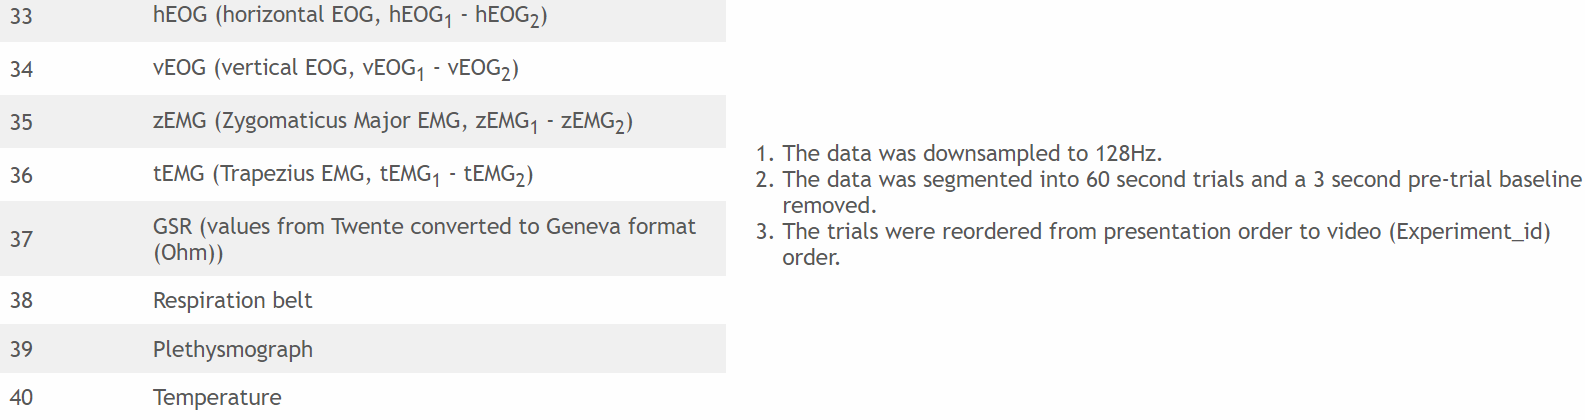

de la 1 a la 32 son las señales EEG

## Espacios Arousal - Valence


- **Excitación (arousal)**: El nivel de activación fisiológica o excitación experimentado en respuesta a un estímulo, que va desde bajo (tranquilo) hasta alto (intenso).

- **Valencia (valence)**: La cualidad emocional o positividad/negatividad de la experiencia subjetiva de un individuo, que va desde negativa (desagradable) hasta positiva (agradable).

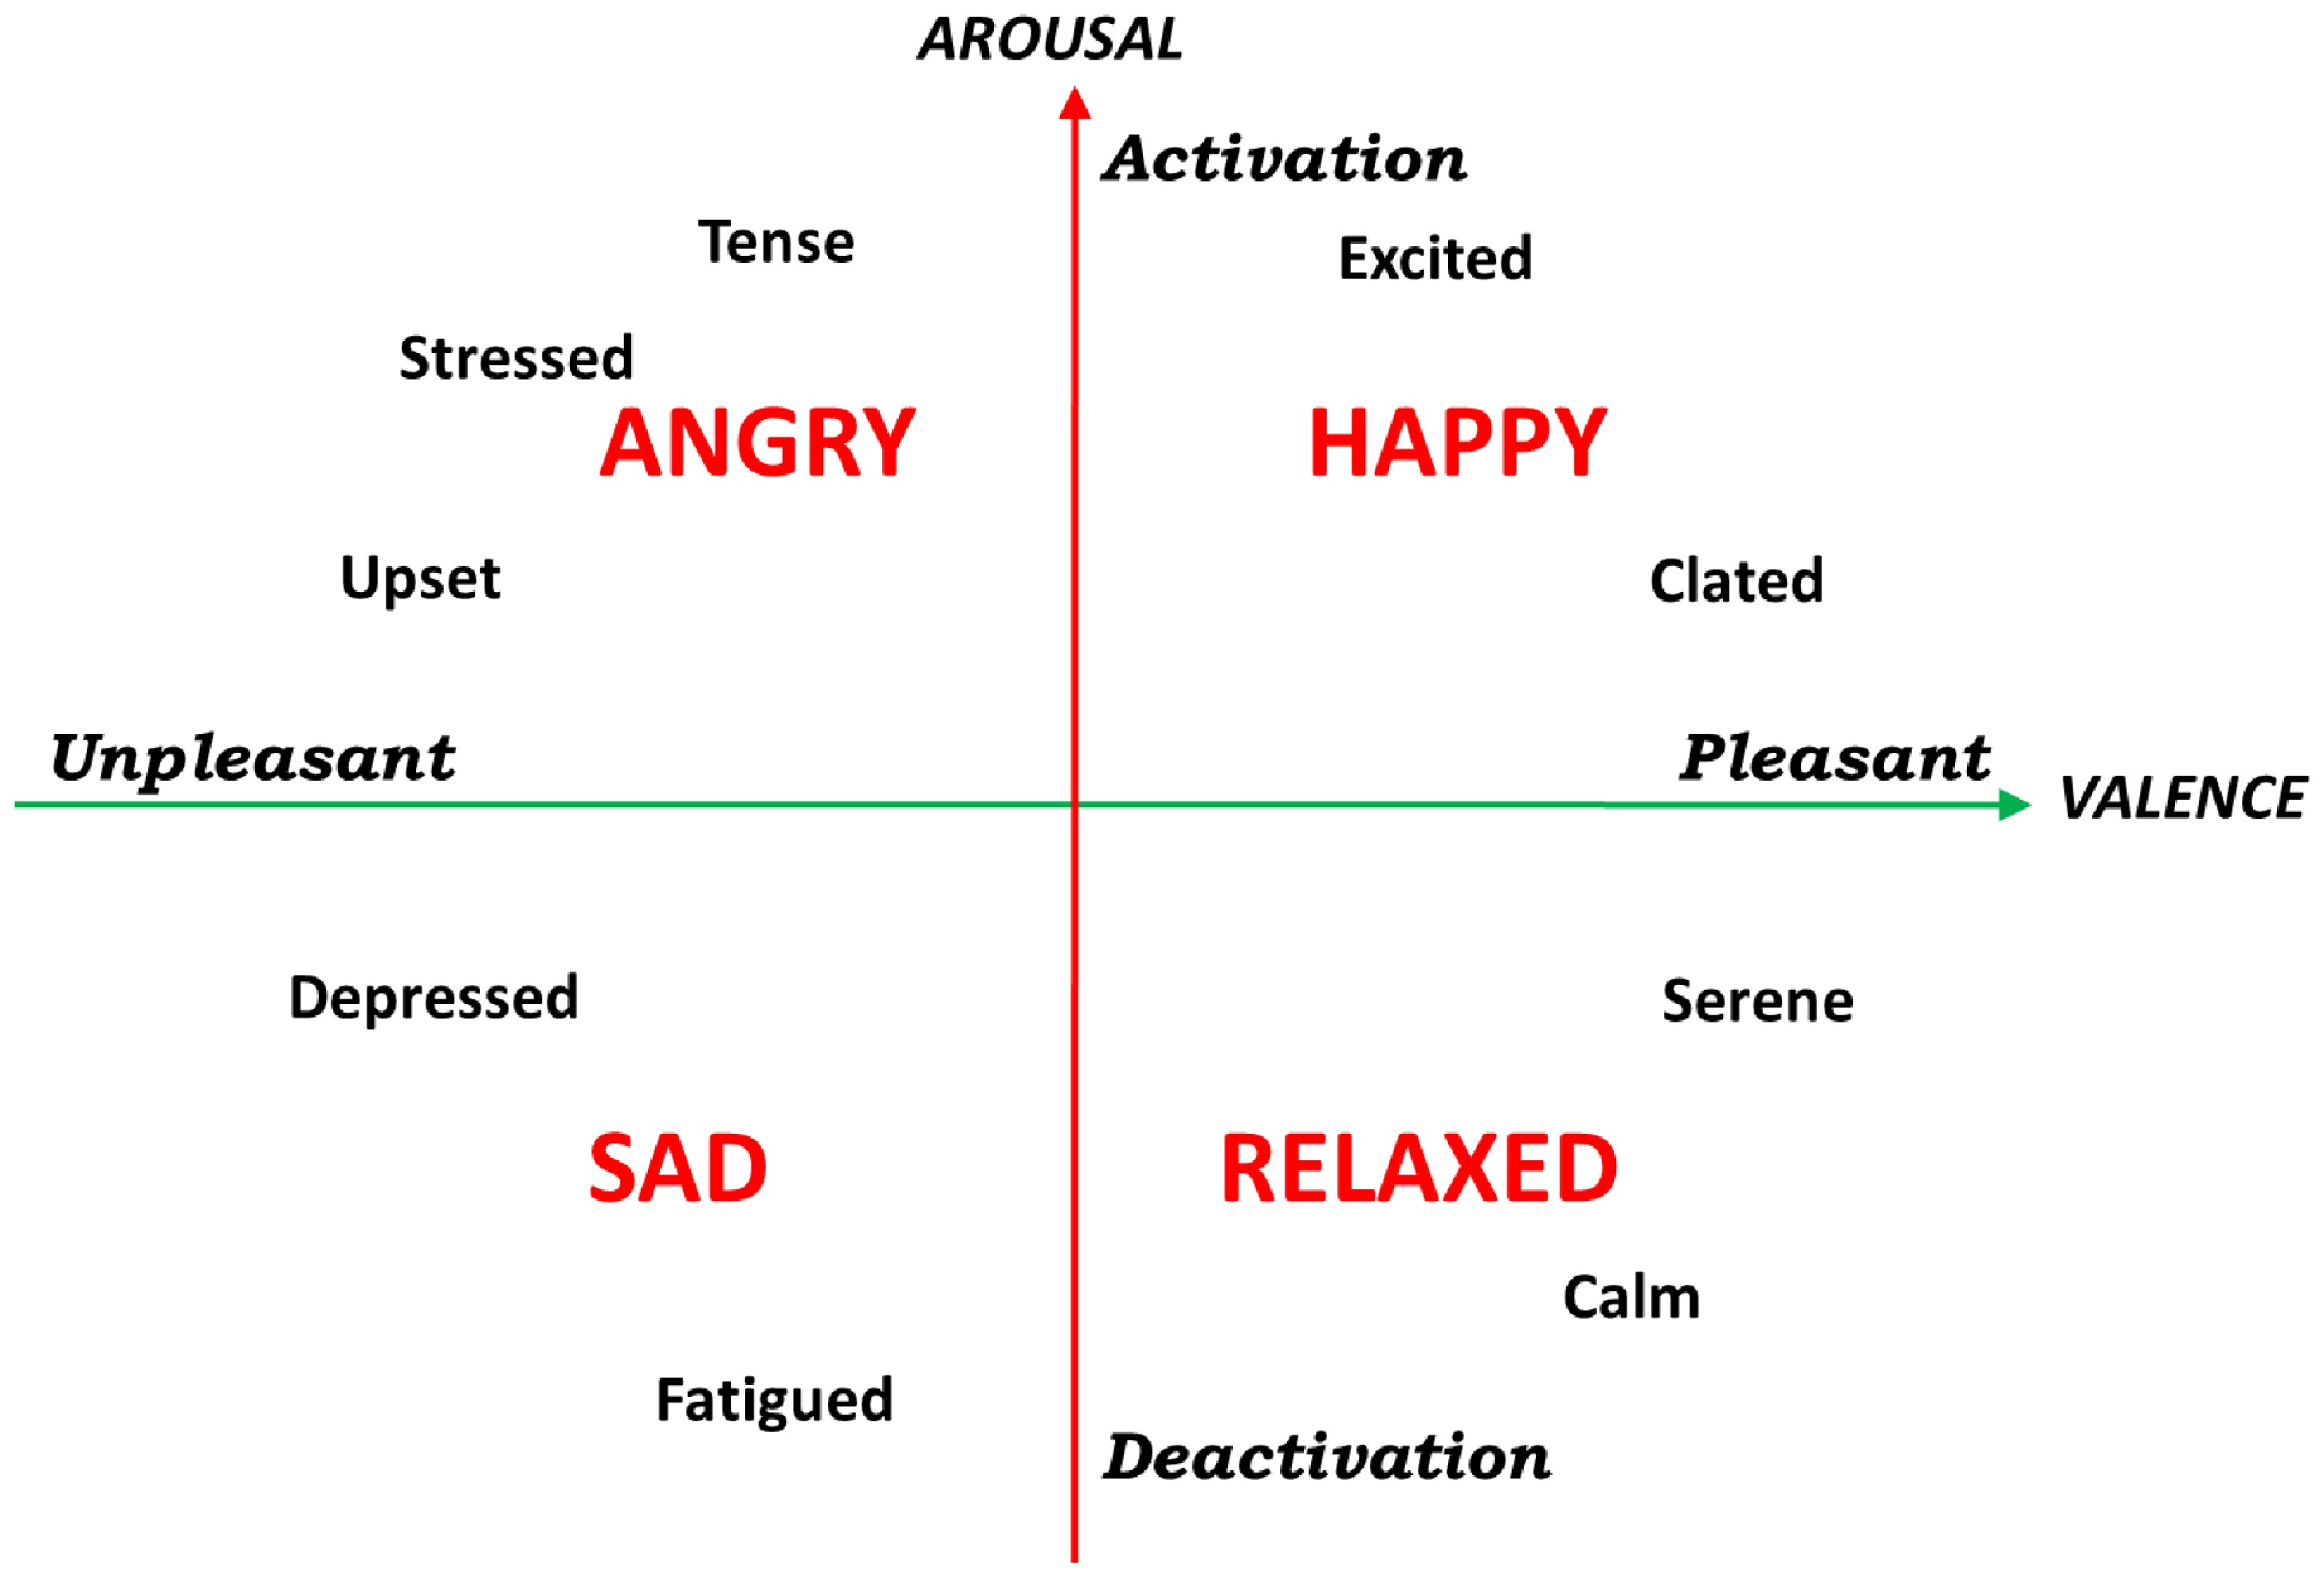

In [ ]:
signals = datosP1['data']
etiquetas = datosP1['labels']   # contiene el arousal y la valencia pra determinar 3 estados de animo (positivo, negativo y neutro)
# Esto me arrojará un nd array de n_video * id_signal * Ntimepoints
# fs que funciona 108.8 (vector temporal) t=np.arange(0, 60, 1.0/108.8)

In [ ]:
# Esto solo es un ejemplo para visualizacion del comportamiento de una de las tantas señales biologicas de la base de datos
GSR = signals[0,36,:]  # 0 --> primer video,  36 --> id de la señal  (37-1),  : --> todas las muestras de la señal
BloodVolume = signals[0,38,:]  # 0 --> primer video,  38 --> id de la señal  (39-1),  : --> todas las muestras de la señal
respiration = signals[0,37,:]   # 0 --> primer video,  37 --> id de la señal  (38-1),  : --> todas las muestras de la señal
Temp = signals[0,39,:]     # 0 --> primer video,  39 --> id de la señal  (40-1),  : --> todas las muestras de la señal
vEOG = signals[0,33,:]    # 0 --> primer video,  33 --> id de la señal  (34-1),  : --> todas las muestras de la señal
EEG_Fp1 = signals[0,0,:]    # 0 --> primer video,  0 --> id de la señal  (1-1),  : --> todas las muestras de la señal

In [ ]:
def normalizar(vector):

  z = np.zeros(len(vector))  # se define el vector normalizado de igual longitud que el original
  min_x = min(vector)      # se halla el minimo valor de los datos originales
  max_x = max(vector)      # se halla el maximo valor de los datos originales
  for i in range(len(vector)):
    z[i] = (vector[i]-min_x)/(max_x-min_x)   # se calcula la ecuacion (1) para todos los datos del arreglo

  return z

In [ ]:
#Se normalizan todos los vectores
GSRn = normalizar(GSR)
Bloodn = normalizar(BloodVolume)
Resn = normalizar(respiration)
Tempn = normalizar(Temp)
vEOGn = normalizar(vEOG)
EEGn = normalizar(EEG_Fp1)

Text(0.5, 1.0, 'EEG Fp1')

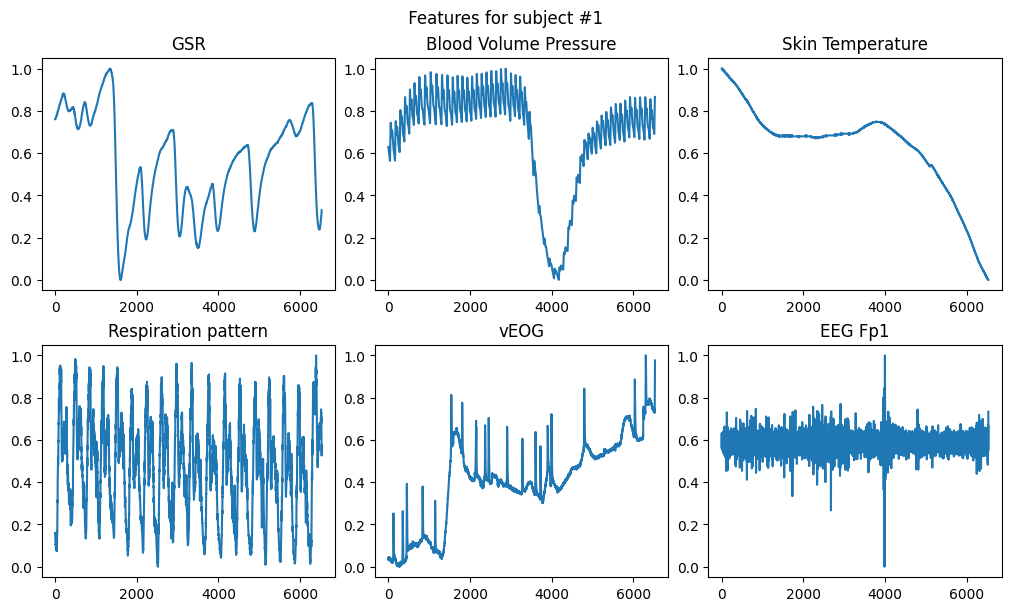

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(10, 6), layout='constrained')
fig.suptitle(' Features for subject #1 ')
axs[0, 0].plot(GSRn)
axs[0, 0].set_title('GSR')
axs[0, 1].plot(Bloodn)
axs[0, 1].set_title('Blood Volume Pressure')
axs[0, 2].plot(Tempn)
axs[0, 2].set_title('Skin Temperature')
axs[1, 0].plot(Resn)
axs[1, 0].set_title('Respiration pattern')
axs[1, 1].plot(vEOGn)
axs[1, 1].set_title('vEOG')
axs[1, 2].plot(EEGn)
axs[1, 2].set_title('EEG Fp1')

Cada Conjunto de características procesado será un vector de ${\bf{x}}\in\mathbb{R}^{D\times 1}$

Lo que realizaremos es construir una matriz de características ${\bf{X}}\in\mathbb{R}^{N\times D}$ donde ${\bf{X}} = \{{\bf{x}}_n\}_{n=1}^{N}$

Seguidamente se organiza dicha matriz en un dataframe, el cual contiene la info de los 4 pacientes con sus 40 videos analizados.

In [ ]:
def calc_emocion(etiquetas):
  arousal = etiquetas[:,1]
  valence = etiquetas[:,0]
  emocion = np.zeros(np.size(arousal))
  emocion[valence<=4] = 0   # emocion negativa
  emocion[np.logical_and(valence>4 ,valence<=7)] = 1   # emocion neutra
  emocion[valence>7] = 2     # emocion positiva
  return emocion

In [ ]:
emocion = calc_emocion(etiquetas)

Ahora se procede a automatizar los calculos de las siguientes caracteristicas de cada señal biologica para los 40 videos del seujeto 1:
1. GSR: average skin resistance, average of derivative, 10 spectral power in the [0-2.4]Hz bands.
2. Blood Volume Pressure: average and standard deviation of HR, HRV, and inter
beat intervals, energy ratio between the frequency bands
[0.04-0.15]Hz and [0.15-0.5]Hz, spectral power in the bands ([0.1-0.2]Hz, [0.2-0.3]Hz, [0.3-0.4]Hz).
3. Respiration Pattern: average respiration signal, mean of
derivative (variation of the respiration signal), 10 spectral power in
the bands from 0 to 2.4Hz.
4. Skin Temperature: average, average of its derivative, spectral power in the
bands ([0-0.1]Hz, [0.1-0.2]Hz).
5. EOG & EMG: eye blinking rate, energy of the signal, mean and variance of the signal.
6. EEG:

In [ ]:
# Función para diseñar y aplicar un filtro Butter
def aplicar_filtro(data,fs, fc, tipo_filtro):
    # Diseñar el filtro
    frecuencia_nyquist = 0.5 *fs
    frecuencia_normalizada = fc / frecuencia_nyquist
    b, a = butter(6, frecuencia_normalizada, btype=tipo_filtro, analog=False)
    data_filtrada = lfilter(b, a, data)

    return data_filtrada

In [ ]:
def plot_spectrum(signal, fs, nperseg=None, noverlap=None):
    # Calcula la STFT
    f, t, Zxx = stft(signal, fs, nperseg=nperseg, noverlap=noverlap)

    # Promedia la magnitud de la STFT en el tiempo para obtener el espectro
    spectrum = np.mean(np.abs(Zxx), axis=1)

    # Visualiza el espectro
    plt.plot(f, spectrum)
    plt.title('Espectro')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Magnitud')
    plt.xlim([0, 1])  # Limita el rango de frecuencias hasta la mitad de la frecuencia de muestreo
    plt.grid(True)
    plt.show()


In [ ]:
fs = 128

# Señales para la GSR
xGSR=[]
xGSR.append(GSRn.mean())
xGSR.append(np.diff(GSRn).mean())
fc = 2.4
pasa_baja_gsr = aplicar_filtro(GSRn,fs, fc, 'low')
#plot_spectrum(pasa_baja_gsr, fs, nperseg=500, noverlap=250)
print(xGSR)

 # cantidad de datos = 6528  ---> 60 sec ,    10 sec ---> 1088

# Señales para la Pletismografia
xBlood=[]
HR=np.zeros(6)
HRV=[]
t = np.arange(0,len(Bloodn))
for i in range(0,6):
  peaks, _ = find_peaks(Bloodn[i*1088:(i+1)*1088], distance=fs//2)
  HR[i] = len(peaks)   # Heart rate cada 10 segundos
  distances = np.diff(t[peaks])
  for j in range(len(distances)):
    HRV.append(distances[j]*(60/len(Bloodn)))  # se transforman las distancias de muestras a tiempo en sec

xBlood.append(HR.mean())   # media de la heart rate en los 6 intervalos de 10 segundos (heart rate casa 10 segundos)
xBlood.append(HR.std())
xBlood.append(np.array(HRV).mean())   # media de la heart rate variability entre todos los intervalos de picos consecutivos
xBlood.append(np.array(HRV).std())
print(xBlood)

# Señales para la Respiracion:
xRes=[]
xRes.append(Resn.mean())
xRes.append(np.diff(Resn).mean())
fc = 2.4
pasa_baja_res = aplicar_filtro(Resn,fs, fc, 'low')
#plot_spectrum(pasa_baja_res, fs, nperseg=500, noverlap=250)
print(xRes)

# Señales para la Temperatura:
xTemp=[]
xTemp.append(Tempn.mean())
xTemp.append(np.diff(Tempn).mean())

[0.5565896898318548, -6.605269828853905e-05]
[9.833333333333334, 0.6871842709362768, 1.0458865149833518, 0.15247967167468704]
[0.4638024326510437, 6.341187365400615e-05]


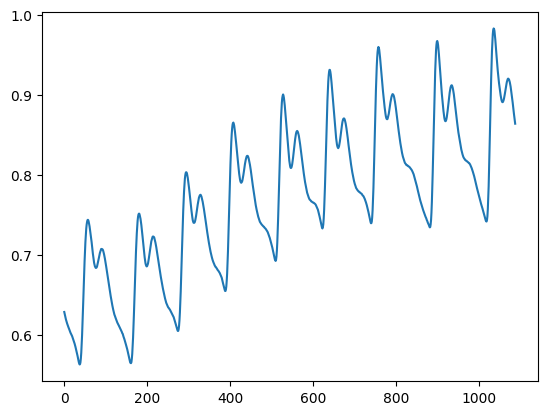

In [ ]:
plt.plot(Bloodn[1088*0:(1088*1)+1])

In [ ]:
# Seaborn nos va a permitir hacer una análisis multivariado
import seaborn as sns
sns.set_theme(style="ticks")
df = sns.load_dataset("penguins")

In [ ]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


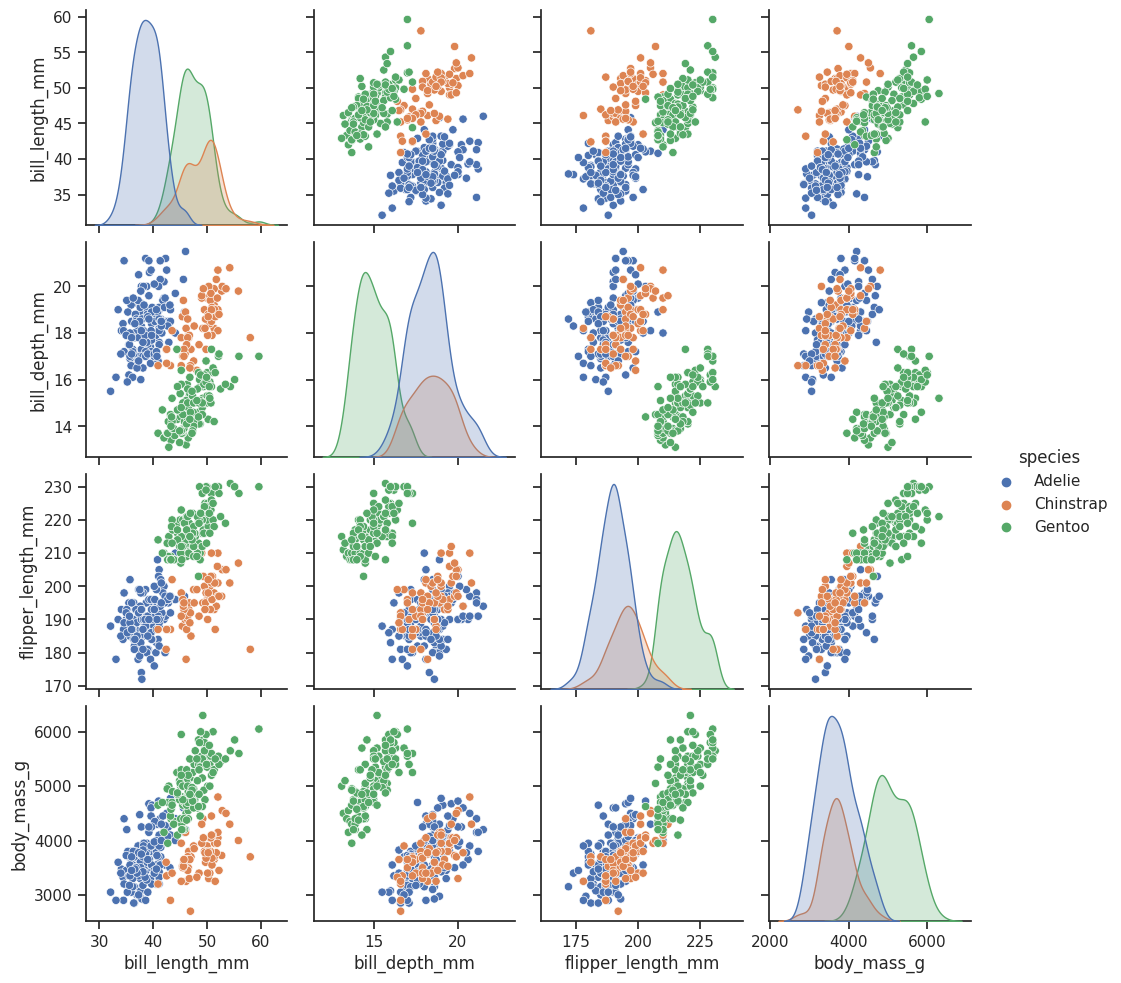

In [ ]:
sns.pairplot(df, hue="species")